In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*was renamed to 'ensure_all_finite'.*")

In [19]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")

df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

,Time Period (T),Home charging (G),Electric car (G),Hybrid electric (G),Company car tax rate (%),Consumer confidence (E),Economic climate perception (E),Willingness to buy (E),Major purchases sentiment (E),Gasoline (Euro95) - Average price (F),Diesel - Average price (F),Total vehicles sold (Target)
0,2007-01-01,0,1,0,22,20.0,37.0,9.0,8.0,1.303032,0.970000,31
1,2007-02-01,0,0,0,22,20.0,37.0,9.0,8.0,1.325357,0.990000,39
2,2007-03-01,0,0,0,22,20.0,37.0,9.0,8.0,1.379032,1.006323,123
3,2007-04-01,0,0,0,22,20.0,37.0,9.0,8.0,1.426500,1.030600,62
4,2007-05-01,0,2,0,22,18.0,32.0,9.0,7.4,1.466516,1.032323,84


In [ ]:
from pprint import pprint

#  Forecast horizon (hoeveel maanden vooruit je voorspelt)
forecast_horizon = 3

#  Splitsing: 80% train, rest voor val/test
n_total = len(df)
n_test = forecast_horizon
n_val = len(df) - int(n_total * 0.8) - n_test
n_train = n_total - n_val - n_test

# 🔁 Chronologische split
train = df.iloc[:n_train].copy()
val = df.iloc[n_train:n_train + n_val].copy()
test = df.iloc[n_train + n_val:].copy()

# 🔎 Print informatie over splits
print(f"Train: {train.shape}, Validation: {val.shape}, Test: {test.shape}")
print(f"Train ends: {train['Time Period (T)'].iloc[-1]}")
print(f"Validation ends: {val['Time Period (T)'].iloc[-1]}")
print(f"Test ends: {test['Time Period (T)'].iloc[-1]}")


print("\nTrain date range:")
print(f"{train['Time Period (T)'].iloc[0]} → {train['Time Period (T)'].iloc[-1]}")

print("\nValidation date range:")
print(f"{val['Time Period (T)'].iloc[0]} → {val['Time Period (T)'].iloc[-1]}")

print("\nTest date range:")
print(f"{test['Time Period (T)'].iloc[0]} → {test['Time Period (T)'].iloc[-1]}")




Train: (173, 12), Validation: (41, 12), Test: (3, 12)
Train ends: 2021-05-01 00:00:00
Validation ends: 2024-10-01 00:00:00
Test ends: 2025-01-01 00:00:00

Train date range:
2007-01-01 00:00:00 → 2021-05-01 00:00:00

Validation date range:
2021-06-01 00:00:00 → 2024-10-01 00:00:00

Test date range:
2024-11-01 00:00:00 → 2025-01-01 00:00:00


## PLot target variable

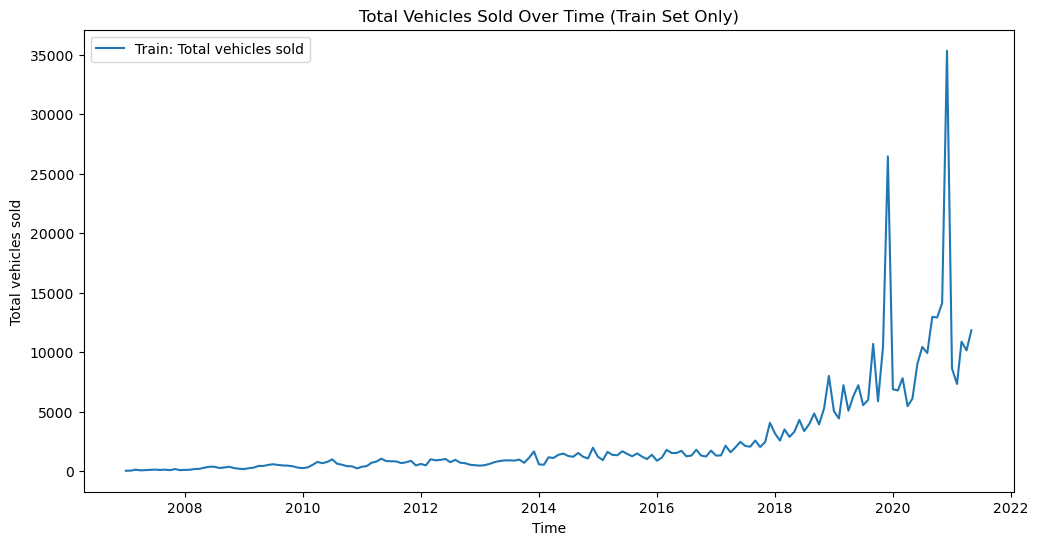

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], train["Total vehicles sold (Target)"], label="Train: Total vehicles sold")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Total Vehicles Sold Over Time (Train Set Only)")
plt.legend()
plt.show()

Optimal lambda for Box-Cox (train): -0.0017


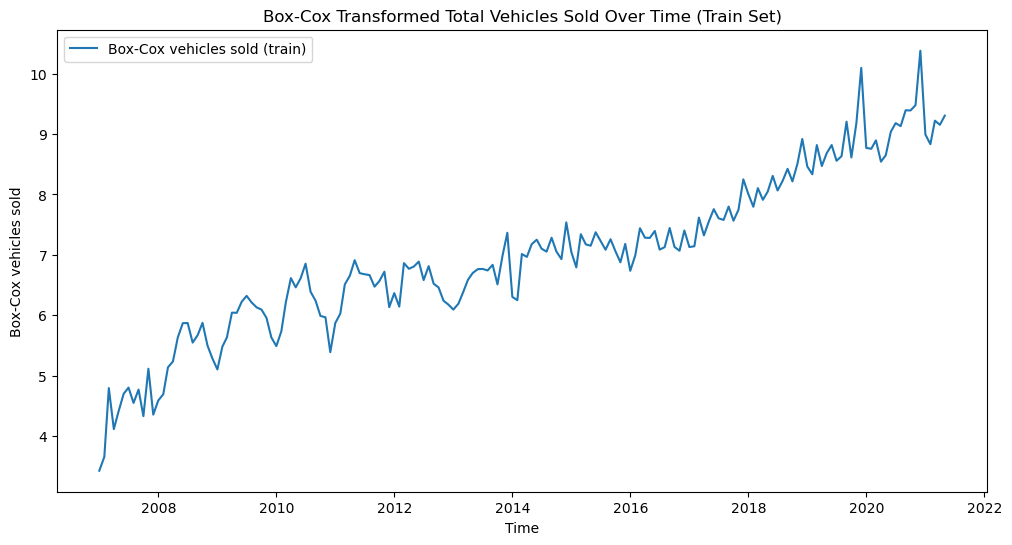

In [5]:
# Select the target column from train set
target_col = 'Total vehicles sold (Target)'
y_train = train[target_col].values

# Box-Cox requires all values > 0
if (y_train <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
y_train_boxcox, fitted_lambda_train = boxcox(y_train)

# Add transformed values to the train dataframe
train['BoxCox vehicles sold (Target)'] = y_train_boxcox

print(f"Optimal lambda for Box-Cox (train): {fitted_lambda_train:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], y_train_boxcox, label="Box-Cox vehicles sold (train)")
plt.xlabel("Time")
plt.ylabel("Box-Cox vehicles sold")
plt.title("Box-Cox Transformed Total Vehicles Sold Over Time (Train Set)")
plt.legend()
plt.show()


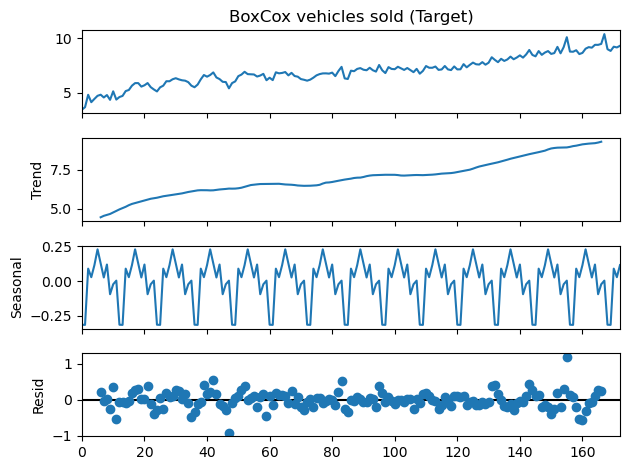

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train["BoxCox vehicles sold (Target)"], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

# Use BoxCox-transformed target from train set
y = train['BoxCox vehicles sold (Target)']

# Augmented Dickey-Fuller test
adf_result = adfuller(y)
print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("ADF p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"ADF Critical Value ({key}): {value:.4f}")
if adf_result[1] < 0.05:
    print("ADF: The series is likely stationary (reject H0).")
else:
    print("ADF: The series is likely non-stationary (fail to reject H0).")

# KPSS test
kpss_result = kpss(y, regression='c', nlags="auto")
print("\nKPSS Statistic: {:.4f}".format(kpss_result[0]))
print("KPSS p-value: {:.4f}".format(kpss_result[1]))
for key, value in kpss_result[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
if kpss_result[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

# Recommended number of differences
adf_ndiffs = ndiffs(y, test='adf')
kpss_ndiffs = ndiffs(y, test='kpss')
print(f"\nRecommended differences (ADF): {adf_ndiffs}")
print(f"Recommended differences (KPSS): {kpss_ndiffs}")

ADF Statistic: -0.2705
ADF p-value: 0.9296
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).

KPSS Statistic: 1.8855
KPSS p-value: 0.0100
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).

Recommended differences (ADF): 1
Recommended differences (KPSS): 1


C:\Users\dylan\AppData\Local\Temp\ipykernel_5844\3267893201.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(y, regression='c', nlags="auto")


ADF Statistic (1st diff): -3.4824
ADF p-value (1st diff): 0.0085
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The differenced series is likely stationary (reject H0).

KPSS Statistic (1st diff): 0.0703
KPSS p-value (1st diff): 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The differenced series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_3492\3029995710.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat_diff, kpss_p_diff, _, kpss_crit_diff = kpss(y_diff, regression='c', nlags="auto")


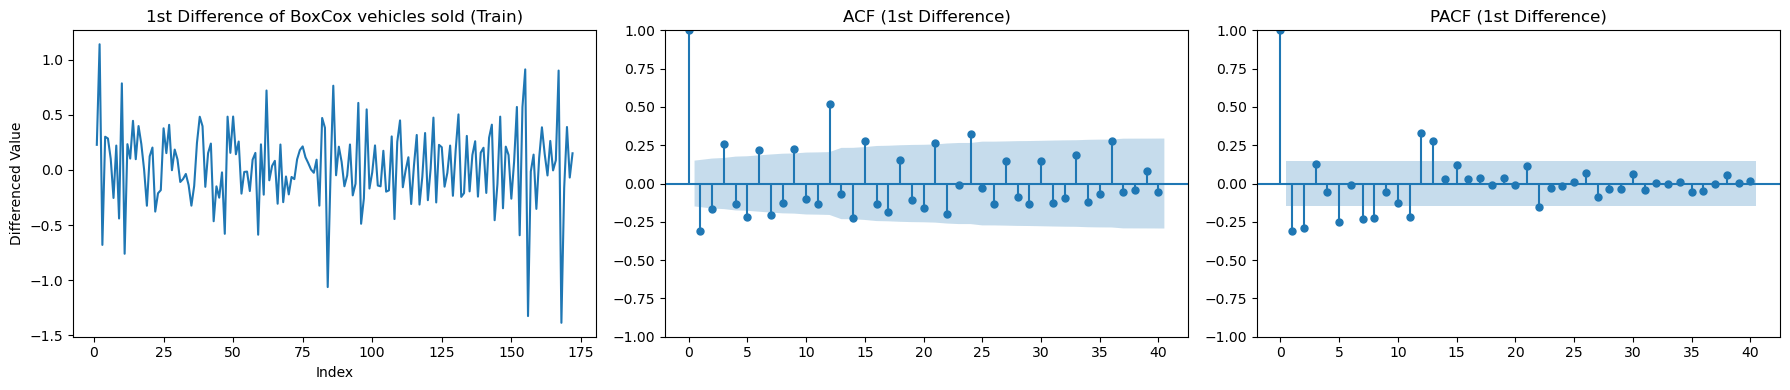

In [8]:
# Apply first difference to the BoxCox-transformed train target
y_diff = train['BoxCox vehicles sold (Target)'].diff().dropna()

# ADF test on differenced series
adf_stat_diff, adf_p_diff, _, _, adf_crit_diff, _ = adfuller(y_diff)
print("ADF Statistic (1st diff): {:.4f}".format(adf_stat_diff))
print("ADF p-value (1st diff): {:.4f}".format(adf_p_diff))
for key, value in adf_crit_diff.items():
    print(f"ADF Critical Value ({key}): {value:.4f}")
if adf_p_diff < 0.05:
    print("ADF: The differenced series is likely stationary (reject H0).")
else:
    print("ADF: The differenced series is likely non-stationary (fail to reject H0).")

# KPSS test on differenced series
kpss_stat_diff, kpss_p_diff, _, kpss_crit_diff = kpss(y_diff, regression='c', nlags="auto")
print("\nKPSS Statistic (1st diff): {:.4f}".format(kpss_stat_diff))
print("KPSS p-value (1st diff): {:.4f}".format(kpss_p_diff))
for key, value in kpss_crit_diff.items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
if kpss_p_diff < 0.05:
    print("KPSS: The differenced series is likely non-stationary (reject H0).")
else:
    print("KPSS: The differenced series is likely stationary (fail to reject H0).")

    # Plot ACF and PACF for the differenced series
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Time series plot
    axes[0].plot(y_diff)
    axes[0].set_title("1st Difference of BoxCox vehicles sold (Train)")
    axes[0].set_xlabel("Index")
    axes[0].set_ylabel("Differenced Value")

    # ACF plot
    plot_acf(y_diff, ax=axes[1], lags=40)
    axes[1].set_title("ACF (1st Difference)")

    # PACF plot
    plot_pacf(y_diff, ax=axes[2], lags=40, method='ywm')
    axes[2].set_title("PACF (1st Difference)")

    plt.tight_layout()
    plt.show()

In [8]:

# Add Box-Cox transformed target to validation set if not present
if 'BoxCox vehicles sold (Target)' not in val.columns:
    # Use the same lambda as for train
    val['BoxCox vehicles sold (Target)'] = boxcox(val['Total vehicles sold (Target)'], lmbda=fitted_lambda_train)

# Define your model configurations
model_configs = {
    "SARIMA(2,0,0)(0,1,1)[12]": {"order": (2, 0, 0), "seasonal_order": (0, 1, 1, 12)},
    "SARIMA(1,0,1)(0,1,1)[12]": {"order": (1, 0, 1), "seasonal_order": (0, 1, 1, 12)},
    "SARIMA(2,0,1)(0,1,0)[12]": {"order": (2, 0, 1), "seasonal_order": (0, 1, 0, 12)},
}

# Store results for comparison
results_summary = []

for name, config in model_configs.items():
    print(f"\nFitting model: {name}")
    
    # Fit on train set only
    model = SARIMAX(
        train["BoxCox vehicles sold (Target)"],
        order=config["order"],
        seasonal_order=config["seasonal_order"],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    result = model.fit(disp=False)
    
    # Forecast for validation period
    val_steps = len(val)
    forecast = result.get_forecast(steps=val_steps)
    preds = forecast.predicted_mean
    actuals = val["BoxCox vehicles sold (Target)"]
    
    # Calculate metrics for validation set
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mape = mean_absolute_percentage_error(actuals, preds) * 100
    
    # Check significance of coefficients (p-values < 0.05)
    pvalues = result.pvalues
    all_significant = (pvalues < 0.05).all()
    
    # Store summary
    results_summary.append({
        "Model": name,
        "AIC (Train)": result.aic,
        "BIC (Train)": result.bic,
        "RMSE (Val)": rmse,
        "MAPE (Val)": mape,
        "All Coeffs Significant": all_significant
    })
    
    print(result.summary())

# Create a DataFrame for quick comparison
summary_df = pd.DataFrame(results_summary).sort_values("AIC (Train)")
print("\n\n Model Comparison:")
print(summary_df)


Fitting model: SARIMA(2,0,0)(0,1,1)[12]
                                      SARIMAX Results                                       
Dep. Variable:        BoxCox vehicles sold (Target)   No. Observations:                  173
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                   2.716
Date:                              Mon, 28 Jul 2025   AIC                              2.568
Time:                                      15:37:33   BIC                             14.557
Sample:                                           0   HQIC                             7.439
                                              - 173                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5868      0.051     11.532      0.000   

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


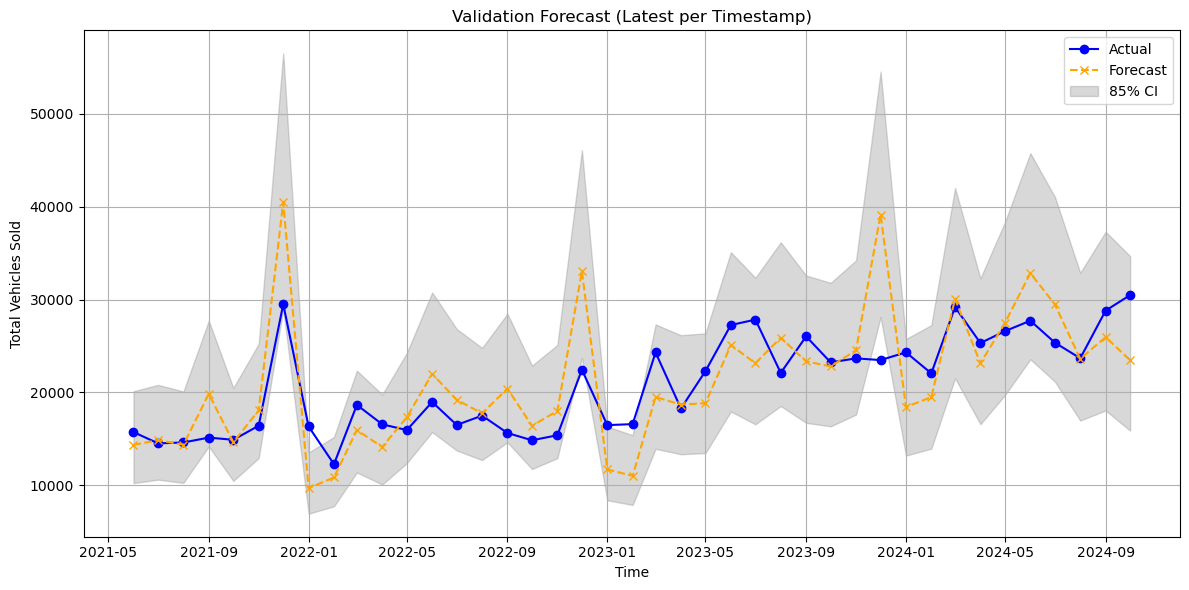

Rolling validation RMSE (mean over windows): 4691.59
Rolling validation MAPE (mean over windows): 18.76%


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from collections import defaultdict

# Ensure boxcox_lambda_target_sales is defined
boxcox_lambda_target_sales = fitted_lambda_train  # or set to the correct lambda value

# Use the actual variables already present in the notebook
# train, val_slice, boxcox_lambda_target_sales, forecast_horizon are already defined

# No need to redefine train, val, or extract columns from empty DataFrames
# boxcox_target_sales_train = train['BoxCox vehicles sold (Target)']  # Not needed
# boxcox_target_sales_val = val_slice['BoxCox vehicles sold (Target)']     # Not needed
# boxcox_lambda_target_sales = fitted_lambda_train                         # Already defined as boxcox_lambda_target_sales

# train is already defined and contains the correct columns

val_rolling_results = []
combined_forecast_dates = []
combined_forecast_values = []
combined_actual_values = []
combined_lower_85 = []
combined_upper_85 = []


# Check of de validatieset groot genoeg is voor rolling forecast
if len(val) < forecast_horizon:
    print(f"⚠️ Validation set ({len(val)} maanden) is te klein voor forecast horizon ({forecast_horizon}). Loop wordt overgeslagen.")
else:
    for start in range(len(val) - forecast_horizon + 1):
        val_slice = val.iloc[start:start + forecast_horizon].copy()
        val_dates = pd.to_datetime(val_slice["Time Period (T)"])

        # Bouw uitgebreide trainset inclusief eerdere validatiepunten
        if start > 0:
            train_expanded = pd.concat([train, val.iloc[:start].copy()])
        else:
            train_expanded = train.copy()

        # Box-Cox target uit uitgebreide trainset
        boxcox_target_sales_train_expanded = train_expanded['BoxCox vehicles sold (Target)']

        # SARIMAX model fitten
        model = SARIMAX(
            boxcox_target_sales_train_expanded,
            order=(1, 0, 1),
            seasonal_order=(0, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)

        # Voorspelling + betrouwbaarheidsinterval (85%)
        forecast_obj = result.get_forecast(steps=forecast_horizon)
        forecast_boxcox = forecast_obj.predicted_mean
        forecast_ci_85 = forecast_obj.conf_int(alpha=0.15)

        # Inverse Box-Cox transformeren
        forecast_back = inv_boxcox(forecast_boxcox.values, boxcox_lambda_target_sales)
        ci_lower_85 = inv_boxcox(forecast_ci_85.iloc[:, 0].values, boxcox_lambda_target_sales)
        ci_upper_85 = inv_boxcox(forecast_ci_85.iloc[:, 1].values, boxcox_lambda_target_sales)

        # Werkelijke waarden uit validatie
        actuals = val_slice["Total vehicles sold (Target)"].values

        # Opslaan per tijdstip
        combined_forecast_dates.extend(val_dates)
        combined_forecast_values.extend(forecast_back)
        combined_actual_values.extend(actuals)
        combined_lower_85.extend(ci_lower_85)
        combined_upper_85.extend(ci_upper_85)

        # Prestatie op dit blokje
        rmse = np.sqrt(mean_squared_error(actuals, forecast_back))
        mape = mean_absolute_percentage_error(actuals, forecast_back)

        val_rolling_results.append({
            "Start": val_dates.iloc[0],
            "End": val_dates.iloc[-1],
            "RMSE": rmse,
            "MAPE": mape
        })

# Aggregate forecasts by date (use last prediction for each timestamp)
forecast_map = {}
actual_map = {}
lower_map = {}
upper_map = {}

for d, f, a, l, u in zip(combined_forecast_dates, combined_forecast_values,
                         combined_actual_values, combined_lower_85, combined_upper_85):
    forecast_map[d] = f
    actual_map[d] = a
    lower_map[d] = l
    upper_map[d] = u

sorted_dates = sorted(forecast_map.keys())
final_forecast = [forecast_map[d] for d in sorted_dates]
final_actuals = [actual_map[d] for d in sorted_dates]
final_lower = [lower_map[d] for d in sorted_dates]
final_upper = [upper_map[d] for d in sorted_dates]

# Compute RMSE and MAPE for the current validation slice
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

actuals = val_slice["Total vehicles sold (Target)"].values
avg_rmse = np.sqrt(mean_squared_error(actuals, forecast_back))
avg_mape = mean_absolute_percentage_error(actuals, forecast_back)

# Plot the full validation forecast
plt.figure(figsize=(12, 6))
sorted_dates = pd.to_datetime(sorted_dates)
plt.plot(sorted_dates, final_actuals, label="Actual", marker="o", color="blue")
plt.plot(sorted_dates, final_forecast, label="Forecast", marker="x", color="orange", linestyle="--")
plt.fill_between(sorted_dates, final_lower, final_upper, color="gray", alpha=0.3, label="85% CI")
plt.title("Validation Forecast (Latest per Timestamp)")
plt.xlabel("Time")
plt.ylabel("Total Vehicles Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Print average RMSE and MAPE over all rolling validation windows
rolling_rmse = [res["RMSE"] for res in val_rolling_results]
rolling_mape = [res["MAPE"] for res in val_rolling_results]

print(f"Rolling validation RMSE (mean over windows): {np.mean(rolling_rmse):.2f}")
print(f"Rolling validation MAPE (mean over windows): {np.mean(rolling_mape)*100:.2f}%")



# Google

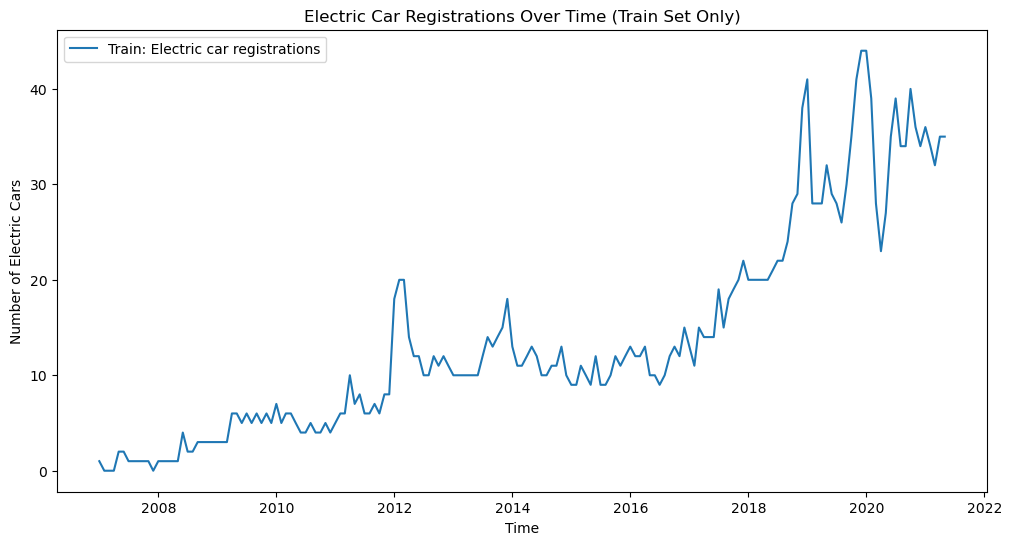

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], train["Electric car (G)"], label="Train: Electric car registrations")
plt.xlabel("Time")
plt.ylabel("Number of Electric Cars")
plt.title("Electric Car Registrations Over Time (Train Set Only)")
plt.legend()
plt.show()

Optimal lambda for Box-Cox (electric car, train): 0.2896


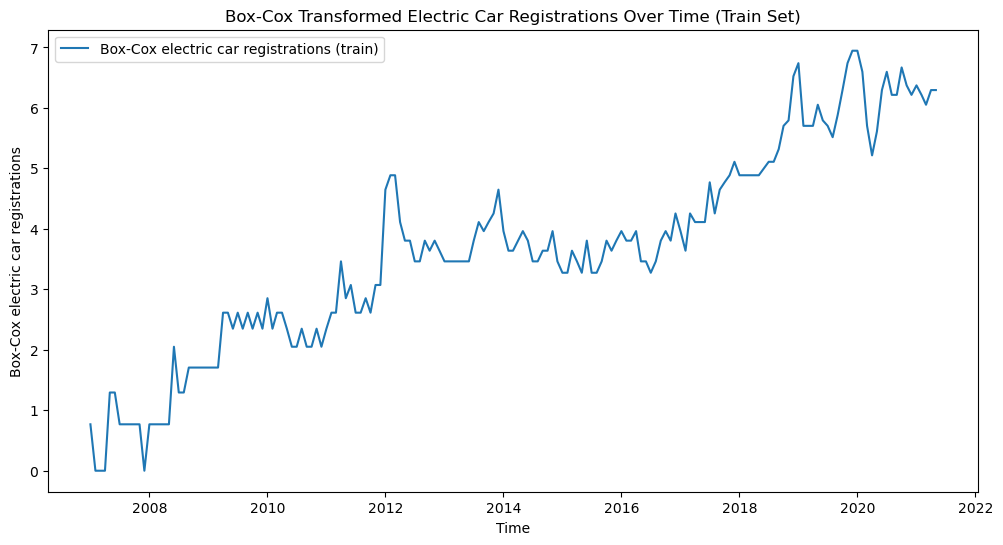

In [11]:
# Select the 'Electric car (G)' column from the train set
electric_car_train = train['Electric car (G)'].values

# If any values are <= 0, shift the entire series by +1 to make all values positive
if (electric_car_train <= 0).any():
    electric_car_train = electric_car_train + 1

# Perform Box-Cox transformation
electric_car_train_boxcox, fitted_lambda_electric_car = boxcox(electric_car_train)

# Add transformed values to the train dataframe
train['BoxCox electric car (G)'] = electric_car_train_boxcox

print(f"Optimal lambda for Box-Cox (electric car, train): {fitted_lambda_electric_car:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], electric_car_train_boxcox, label="Box-Cox electric car registrations (train)")
plt.xlabel("Time")
plt.ylabel("Box-Cox electric car registrations")
plt.title("Box-Cox Transformed Electric Car Registrations Over Time (Train Set)")
plt.legend()
plt.show()

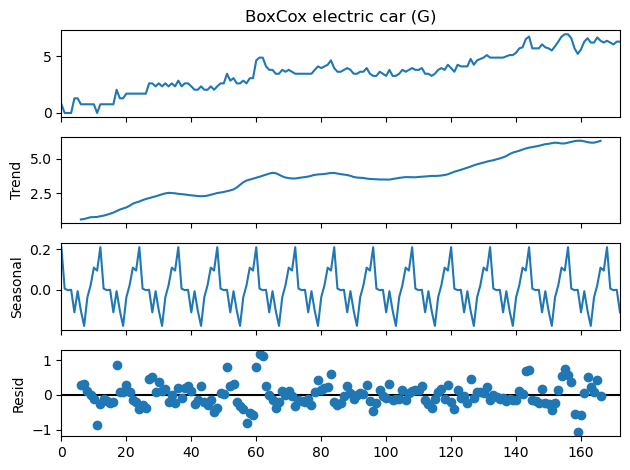

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the Box-Cox transformed electric car registrations (train set)
decomp_electric = seasonal_decompose(train['BoxCox electric car (G)'], model='additive', period=12)
decomp_electric.plot()
plt.tight_layout()
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey-Fuller test
adf_stat, adf_p, _, _, adf_crit, _ = adfuller(electric_car_train)
print("ADF Statistic:", adf_stat)
print("ADF p-value:", adf_p)
for key, value in adf_crit.items():
    print(f"ADF Critical Value ({key}): {value}")
if adf_p < 0.05:
    print("ADF: The series is likely stationary (reject H0).")
else:
    print("ADF: The series is likely non-stationary (fail to reject H0).")

# KPSS test
kpss_stat, kpss_p, _, kpss_crit = kpss(electric_car_train, regression='c', nlags="auto")
print("\nKPSS Statistic:", kpss_stat)
print("KPSS p-value:", kpss_p)
for key, value in kpss_crit.items():
    print(f"KPSS Critical Value ({key}): {value}")
if kpss_p < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

ADF Statistic: 0.26371122691896964
ADF p-value: 0.9756169315557284
ADF Critical Value (1%): -3.472161410886292
ADF Critical Value (5%): -2.8798954259680936
ADF Critical Value (10%): -2.5765565828092245
ADF: The series is likely non-stationary (fail to reject H0).

KPSS Statistic: 1.6752869280119898
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.347
KPSS Critical Value (5%): 0.463
KPSS Critical Value (2.5%): 0.574
KPSS Critical Value (1%): 0.739
KPSS: The series is likely non-stationary (reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_5844\3215813635.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(electric_car_train, regression='c', nlags="auto")


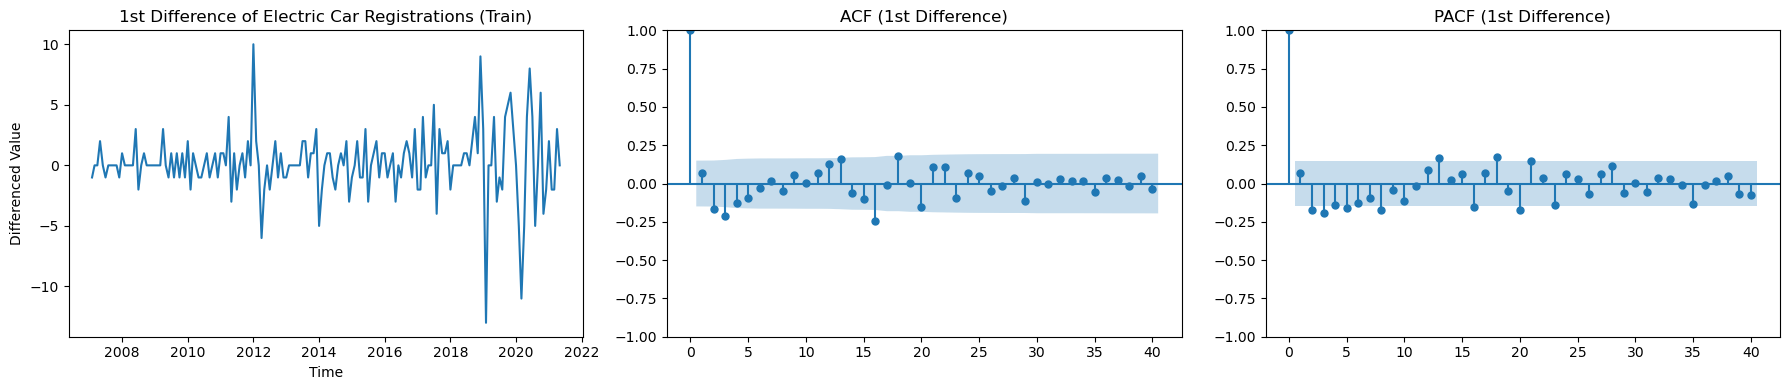

ADF Statistic (1st diff): -3.5596
ADF p-value (1st diff): 0.0066
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The differenced series is likely stationary (reject H0).

KPSS Statistic (1st diff): 0.1323
KPSS p-value (1st diff): 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The differenced series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_5844\1575993241.py:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat_diff, kpss_p_diff, _, kpss_crit_diff = kpss(electric_car_train_diff, regression='c', nlags="auto")


In [13]:
# First order difference on electric_car_train
electric_car_train_diff = np.diff(electric_car_train, n=1)

# Plot time series, ACF, and PACF for the differenced series
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Time series plot
axes[0].plot(train["Time Period (T)"].iloc[1:], electric_car_train_diff)
axes[0].set_title("1st Difference of Electric Car Registrations (Train)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Differenced Value")

# ACF plot
plot_acf(electric_car_train_diff, ax=axes[1], lags=40)
axes[1].set_title("ACF (1st Difference)")

# PACF plot
plot_pacf(electric_car_train_diff, ax=axes[2], lags=40, method='ywm')
axes[2].set_title("PACF (1st Difference)")

plt.tight_layout()
plt.show()

# ADF test on differenced electric car registrations
adf_stat_diff, adf_p_diff, _, _, adf_crit_diff, _ = adfuller(electric_car_train_diff)
print("ADF Statistic (1st diff): {:.4f}".format(adf_stat_diff))
print("ADF p-value (1st diff): {:.4f}".format(adf_p_diff))
for key, value in adf_crit_diff.items():
    print(f"ADF Critical Value ({key}): {value:.4f}")
if adf_p_diff < 0.05:
    print("ADF: The differenced series is likely stationary (reject H0).")
else:
    print("ADF: The differenced series is likely non-stationary (fail to reject H0).")

# KPSS test on differenced electric car registrations
kpss_stat_diff, kpss_p_diff, _, kpss_crit_diff = kpss(electric_car_train_diff, regression='c', nlags="auto")
print("\nKPSS Statistic (1st diff): {:.4f}".format(kpss_stat_diff))
print("KPSS p-value (1st diff): {:.4f}".format(kpss_p_diff))
for key, value in kpss_crit_diff.items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
if kpss_p_diff < 0.05:
    print("KPSS: The differenced series is likely non-stationary (reject H0).")
else:
    print("KPSS: The differenced series is likely stationary (fail to reject H0).")

In [17]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Assumptions: the following variables are already defined:
# - train['BoxCox vehicles sold (Target)']
# - electric_car_train_diff
# - val['Electric car (G)']
# - val['BoxCox vehicles sold (Target)']

# Step 1: Compare multiple lags on training set
lag_results = []
max_lag = 12

for lag in range(1, max_lag + 1):
    # Create lagged exogenous series
    exog_lagged = pd.Series(electric_car_train_diff).shift(lag)

    # Align target and exog by dropping NaNs
    aligned_df = pd.concat([
        train['BoxCox vehicles sold (Target)'],
        exog_lagged.rename('exog')
    ], axis=1).dropna()

    aligned_target = aligned_df['BoxCox vehicles sold (Target)']
    aligned_exog = aligned_df['exog']

    # Fit SARIMAX
    model = SARIMAX(
        aligned_target,
        exog=aligned_exog.values.reshape(-1, 1),
        order=(1, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    preds = result.fittedvalues
    rmse = np.sqrt(mean_squared_error(aligned_target, preds))

    # Store results
    lag_results.append({
        "Lag": lag,
        "RMSE": rmse,
        "AIC": result.aic,
        "BIC": result.bic,
        "Coefficient p-value": result.pvalues.iloc[-1],
        "Log Likelihood": result.llf
    })

# Step 2: Show summary
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\nLag Comparison Summary:")
print(lag_df)

# Step 3: Evaluate best lag (e.g., lag 2) on validation set
chosen_lag = 2

# Prepare training data with lagged exogenous
exog_train_lag = pd.Series(electric_car_train_diff).shift(chosen_lag)
train_df = pd.concat([
    train['BoxCox vehicles sold (Target)'],
    exog_train_lag.rename('exog')
], axis=1).dropna()

target_train_lag = train_df['BoxCox vehicles sold (Target)']
exog_train_lag = train_df['exog']

# Fit SARIMAX on train set
model_exog = SARIMAX(
    target_train_lag,
    exog=exog_train_lag.values.reshape(-1, 1),
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_exog = model_exog.fit(disp=False)

# Prepare validation data
val_exog_lag = val['Electric car (G)'].diff().shift(chosen_lag)
val_df = pd.concat([
    val['BoxCox vehicles sold (Target)'],
    val_exog_lag.rename('exog')
], axis=1).dropna()

val_target_lag = val_df['BoxCox vehicles sold (Target)'].reset_index(drop=True)
val_exog_lag = val_df['exog'].reset_index(drop=True)

# Forecast
forecast_steps = len(val_target_lag)
forecast_result = result_exog.get_forecast(
    steps=forecast_steps,
    exog=val_exog_lag.values.reshape(-1, 1)
)
preds_val = forecast_result.predicted_mean

# Evaluate
rmse_val = np.sqrt(mean_squared_error(val_target_lag, preds_val))
print(f"\nValidation RMSE (SARIMAX + exogenous lag {chosen_lag}): {rmse_val:.3f}")


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.


Lag Comparison Summary:
    Lag      RMSE       AIC        BIC  Coefficient p-value  Log Likelihood
1     2  0.572683 -6.788387   8.060679         1.188165e-25        8.394194
0     1  0.520093 -6.468235   8.415434         6.650919e-24        8.234117
2     3  0.536938 -6.075305   8.738918         1.025030e-25        8.037653
3     4  0.556574 -4.349202  10.429934         1.624289e-23        7.174601
5     6  0.603879 -3.224405  11.483807         6.891214e-23        6.612203
4     5  0.584689 -3.154831  11.588968         1.187339e-24        6.577416
6     7  0.607605 -2.626595  12.045774         3.459641e-22        6.313298
7     8  0.612692 -1.022019  13.614249         1.780077e-23        5.511010
10   11  0.594591 -0.248976  14.277398         4.007870e-22        5.124488
8     9  0.580940  0.541289  15.141194         6.183806e-22        4.729355
9    10  0.650623  1.327013  15.890287         2.407727e-22        4.336494
11   12  0.620024  2.236585  16.725784         2.485541e-22    

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Validation RMSE (SARIMAX + exogenous lag 2): 0.473


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Validation RMSE (SARIMAX + exogenous lag 2): 0.473
        Date  Actual (BoxCox)  Predicted (BoxCox)
0 2021-09-01         9.547902            9.156154
1 2021-10-01         9.532248            9.407245
2 2021-11-01         9.627619            9.342275
3 2021-12-01        10.203991            9.388407
4 2022-01-01         9.622634            9.653020


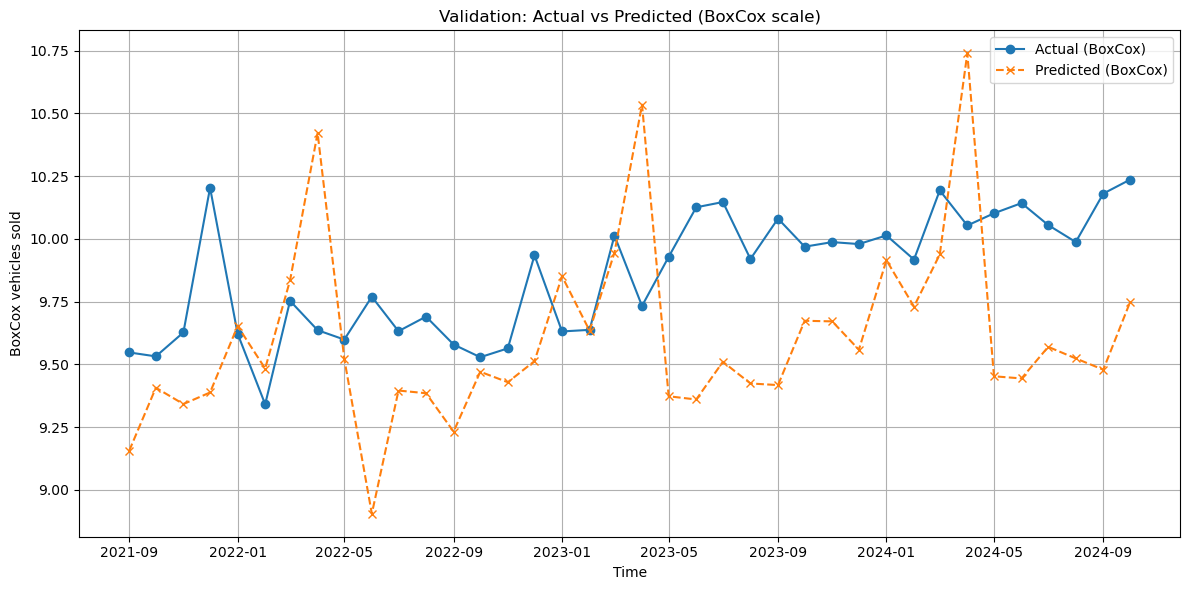

In [ ]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pandas as pd

# --- Parameters ---
lag = 2

# --- Train set preparation ---
train_lagged_df = train.copy()
train_lagged_df["exog_lag2"] = pd.Series(electric_car_train_diff).shift(lag)

# Drop NaNs in either target or exog
train_lagged_df = train_lagged_df.dropna(subset=["BoxCox vehicles sold (Target)", "exog_lag2"])

y_train = train_lagged_df["BoxCox vehicles sold (Target)"]
X_train = train_lagged_df["exog_lag2"]

# --- Validation set preparation ---
val_lagged_df = val.copy()

# Compute diff + lagged exog for validation
val_lagged_df["exog_lag2"] = val["Electric car (G)"].diff().shift(lag)
val_lagged_df = val_lagged_df.dropna(subset=["BoxCox vehicles sold (Target)", "exog_lag2"])

y_val = val_lagged_df["BoxCox vehicles sold (Target)"]
X_val = val_lagged_df["exog_lag2"]

# --- Fit SARIMAX model ---
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit(disp=False)

# --- Forecast with validation exog ---
n_val = len(y_val)
forecast = result.get_forecast(steps=n_val, exog=X_val)
preds = forecast.predicted_mean

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"Validation RMSE (SARIMAX + exogenous lag 2): {rmse:.3f}")

# Print actual vs predicted (BoxCox scale)
results_df = pd.DataFrame({
    "Date": val_lagged_df["Time Period (T)"].values,
    "Actual (BoxCox)": y_val.values,
    "Predicted (BoxCox)": preds.values
})
print(results_df.head())

# Plot actual vs predicted (BoxCox scale)
plt.figure(figsize=(12, 6))
plt.plot(results_df["Date"], results_df["Actual (BoxCox)"], label="Actual (BoxCox)", marker="o")
plt.plot(results_df["Date"], results_df["Predicted (BoxCox)"], label="Predicted (BoxCox)", marker="x", linestyle="--")
plt.xlabel("Time")
plt.ylabel("BoxCox vehicles sold")
plt.title("Validation






: Actual vs Predicted (BoxCox scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()